In [14]:
from cognipy.ontology import Ontology
from cognipy.ontology import CQL
from cognipy.ontology import ABoxBatch
from cognipy.ontology import encode_string_for_graph_label
from cognipy.edit import CnlEditBox
from cognipy.edit import CnlQueryForConcept

import random
import textwrap
import numpy as np
import pandas as pd
import pickle

def graph_attribute_formatter(val):
    if isinstance(val,list) or isinstance(val,set):
        return " | ".join(list(map(lambda i:encode_string_for_graph_label(graph_attribute_formatter(i)),val)))
    elif isinstance(val,dict):
        return " | ".join(list(map(lambda i:i[0]+" : "+encode_string_for_graph_label(graph_attribute_formatter(i[1])),val.items())))
    else:
        return encode_string_for_graph_label(textwrap.fill(str(val),40))

from pint import UnitRegistry
ureg = UnitRegistry()
Q = ureg.Quantity

def Qstr(a):
    return "Q('"+str(a)+"')"
Q.__repr__=Qstr    


In [18]:
rd_c=CnlEditBox('virus.encnl')
rd_c

In [19]:
onto = Ontology("cnl/string",
                    rd_c.getvalue(), 
                    evaluator = lambda e:eval(e,globals(),locals()), 
                    graph_attribute_formatter = graph_attribute_formatter)

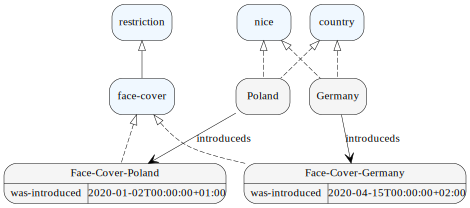

In [20]:
onto.draw_graph(layout='hierarchical')

In [33]:
onto.select_instances_of("a face-cover")

,Instance,was-introduced
0,Face-Cover-Germany,2020-04-15T00:00:00+10:00
1,Face-Cover-Poland,2020-01-02T00:00:00+11:00


In [34]:
df=onto.sparql_query(CQL("""select ?a1 ?a2 ?d{
                            ?a1 rdf:type <country>. 
                            ?a2 rdf:type <restriction>. 
                            ?a1 <introduceds> ?a2. 
                            ?a2 <was-introduced> ?d.
                        }"""))

In [35]:
df

,a1,a2,d
0,Germany,Face-Cover-Germany,2020-04-15T00:00:00+10:00
1,Poland,Face-Cover-Poland,2020-01-02T00:00:00+11:00


In [36]:
df.set_index("d").resample("d").join(case.set_index("date"))

,a1,a2
d,,
2020-04-15T00:00:00+10:00,Germany,Face-Cover-Germany
2020-01-02T00:00:00+11:00,Poland,Face-Cover-Poland
